## **make_moon 데이터셋 RandomTree**

1. noise=0.4인 1000개의 데이터셋을 생성합니다.
2. train_test_split() 을 사용해 훈련 셋과 테스트 셋으로 나눕니다.
3. 분류를 위한 결정 트리를 생성합니다.
4. 찾은 매개변수를 사용해 전체 훈련 셋에 대해 모델을 훈련시키고 테스트 셋에서 성능을 측정합니다.
5. 최적의 매개변수를 찾기 위해 1.결정 트리의 최대 깊이, 2.리프 노드가 가지고 있어야 할 최소 샘플 개수, 3.random state를 조절하여 성능을 최대한 높이세요.
6. 최종 결정 트리를 시각화 하세요.
7. 데이터 및 결정경계에 대해 시각화 하세요.

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
# noise=0.4인 1000개의 데이터셋을 생성
X_moons, y_moons = make_moons(n_samples=1000, noise=0.4, random_state=40)
# train, test 데이터 split
X_train, X_test, y_train, y_test = train_test_split( X_moons, y_moons, test_size=0.3, random_state=40)

### 최적의 매개변수를 찾기 위해서 Grid Search 방법을 사용하여 실험을 진행
- **파라미터 설정**
  - max_depth : [None, 10, 20, 30, 40, 50]
  - min_samples_leaf : [1, 2, 4, 6, 8, 10]

- **최적화 기준 metric** : accuracy

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# 결정 트리 생성
tree_clf = DecisionTreeClassifier(random_state=40)

# 최적의 매개변수를 찾기 위한 그리드 서치 설정
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'random_state': [40]
}

# 그리드 서치 실행
grid_search = GridSearchCV(tree_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=40),
             param_grid={'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 4, 6, 8, 10],
                         'random_state': [40]},
             scoring='accuracy')

In [34]:
# 최적의 매개변수 사용
best_tree_clf = grid_search.best_estimator_

In [32]:
# 최적의 매개변수 출력
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': None, 'min_samples_leaf': 10, 'random_state': 40}


Grid Search 최적화 결과, **max_depth는 적용하지 않고(None), min_sample_leaf는 10으로 적용했을 때 가장 높은 accuracy에 달성**하였다.

해당 결과가 가장 최적인 결과임을 확인하기 위해서 grid_search를 진행한 파라미터 조합에 대한 accuracy 그래프를 시각화해보았다.

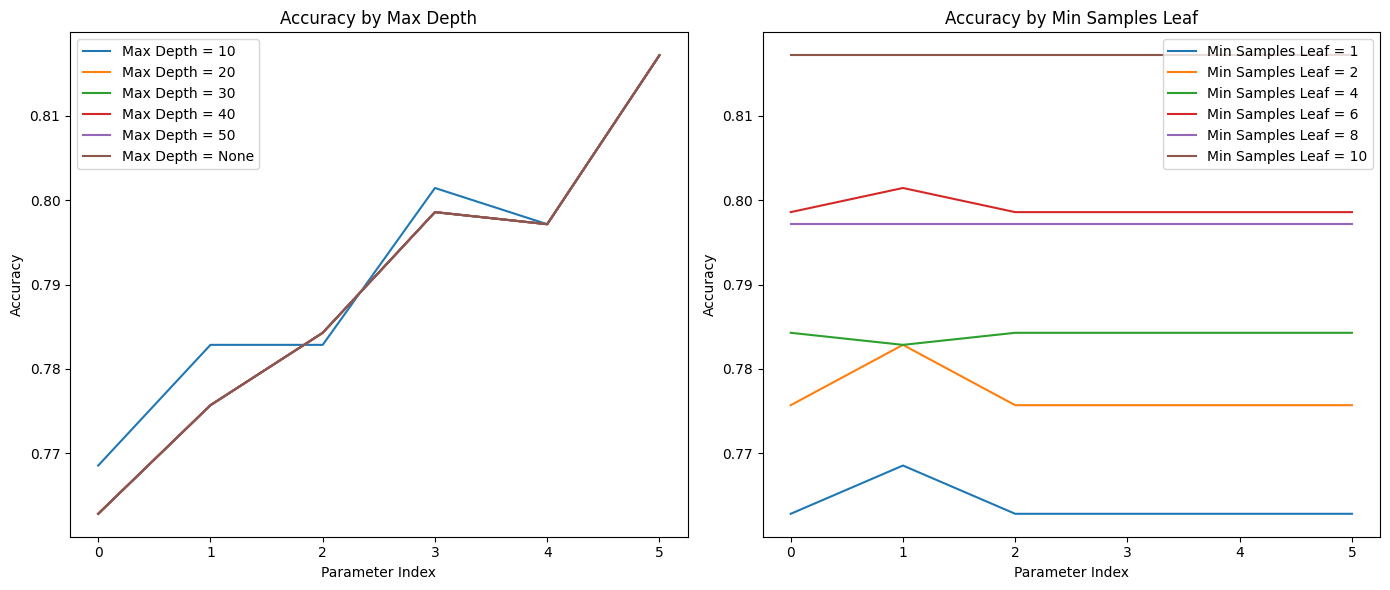

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# GridSearchCV의 결과를 추출
cv_results = grid_search.cv_results_
scores = cv_results['mean_test_score']
params = cv_results['params']

# 매개변수별로 데이터 구성
max_depth_scores = {}
min_samples_leaf_scores = {}

for score, param in zip(scores, params):
    max_depth = param['max_depth'] if param['max_depth'] is not None else float('inf')
    min_samples_leaf = param['min_samples_leaf']

    if max_depth not in max_depth_scores:
        max_depth_scores[max_depth] = []
    max_depth_scores[max_depth].append(score)

    if min_samples_leaf not in min_samples_leaf_scores:
        min_samples_leaf_scores[min_samples_leaf] = []
    min_samples_leaf_scores[min_samples_leaf].append(score)


plt.figure(figsize=(14, 6))

# max_depth에 따른 정확도 그래프
plt.subplot(1, 2, 1)
for depth in sorted(max_depth_scores, key=lambda x: (x is float('inf'), x)):
    label = 'None' if depth == float('inf') else depth
    plt.plot(max_depth_scores[depth], label=f'Max Depth = {label}')
plt.title('Accuracy by Max Depth')
plt.xlabel('Parameter Index')
plt.ylabel('Accuracy')
plt.legend()

# min_samples_leaf에 따른 정확도 그래프
plt.subplot(1, 2, 2)
for leaf in sorted(min_samples_leaf_scores):
    plt.plot(min_samples_leaf_scores[leaf], label=f'Min Samples Leaf = {leaf}')
plt.title('Accuracy by Min Samples Leaf')
plt.xlabel('Parameter Index')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



**[결과 분석]**
1. Max Depth에 따른 정확도 시각화 결과, max_depth를 None으로 설정하였을때, 가장 정확도 급격하게 상승함을 확인 할 수 있었다. 이는 max_depth가 none일때 트리 깊이의 제한이 없어 가장 깊게 분류할 수 있는 경우이고, 가장 데이터를 잘 설명할 수 있는 파라미터임을 확인 할 수 있었다. 하지만, 규제가 적용되지 않았기 때문에 과적합 가능성이 높다.

2. Min Samples leaf에 따른 정확도 시각화 결과, min_samples_leaf를 10으로 설정하였을 때 가장 정확도가 높았음을 확인 할 수 있었고, min sample leaf가 높을수록 모델의 정확도가 높아지는 경향을 확인할 수 있었다. 이를 통해 리프노드가 가지는 최소 샘플 수가 많을 수록 훈련데이터의 이상치나 노이즈 데이터에 덜 민감하게 반응하여 좋은 성능을 보인 것을 확인 할 수 있었다.

결정 트리에서는 과대적합을 피하기 위해 규제 파라미터를 사용해 자유도를 제한할 수 있고, 이번 실험에서는 max_depth와 min_samples_leaf를 규제 파라미터로 설정하였다. 실험 결과, max_depth를 최소화하고, min_samples_leaf를 최대로 하여 규제를 가장 크게 설정했을 때 가장 좋은 성능을 보임을 확인하였다.

In [33]:
# 모델 훈련 및 테스트 데이터셋에서의 성능 평가
y_pred = best_tree_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", accuracy)


Test set accuracy: 0.8266666666666667


In [20]:
# Decision Tree 결정경계 시각화
def plot_decision_boundary(clf, X, y, axes, cmap):
  x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100), np.linspace(axes[2], axes[3], 100))
  X_new = np.c_[x1.ravel(), x2.ravel()]
  y_pred = clf.predict(X_new).reshape(x1.shape)

  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
  plt.contour(x1, x2, y_pred, cmap='Greys', alpha=0.8)
  colors = {"Wistia": ["#78785c", '#c47b27'], 'Pastel1': ['red', 'blue']}
  markers = ('o', '^')
  for idx in (0,1):
    plt.plot(X[:,0][y == idx], X[: ,1][y == idx], color=colors[cmap][idx], marker=markers[idx], linestyle='none')
    plt.axis(axes)
    plt.xlabel(r'$x_1$')
    plt.ylabel(R'$x_2$', rotation=0)



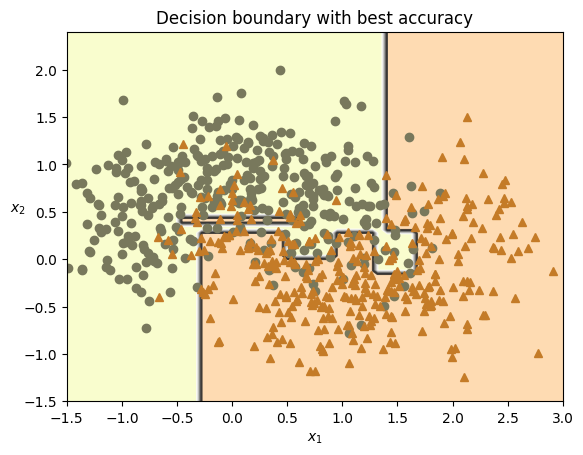

In [24]:
plot_decision_boundary(best_tree_clf, X_train, y_train, axes=[-1.5, 3, -1.5, 2.4], cmap='Wistia')
plt.title("Decision boundary with best accuracy")
plt.show()

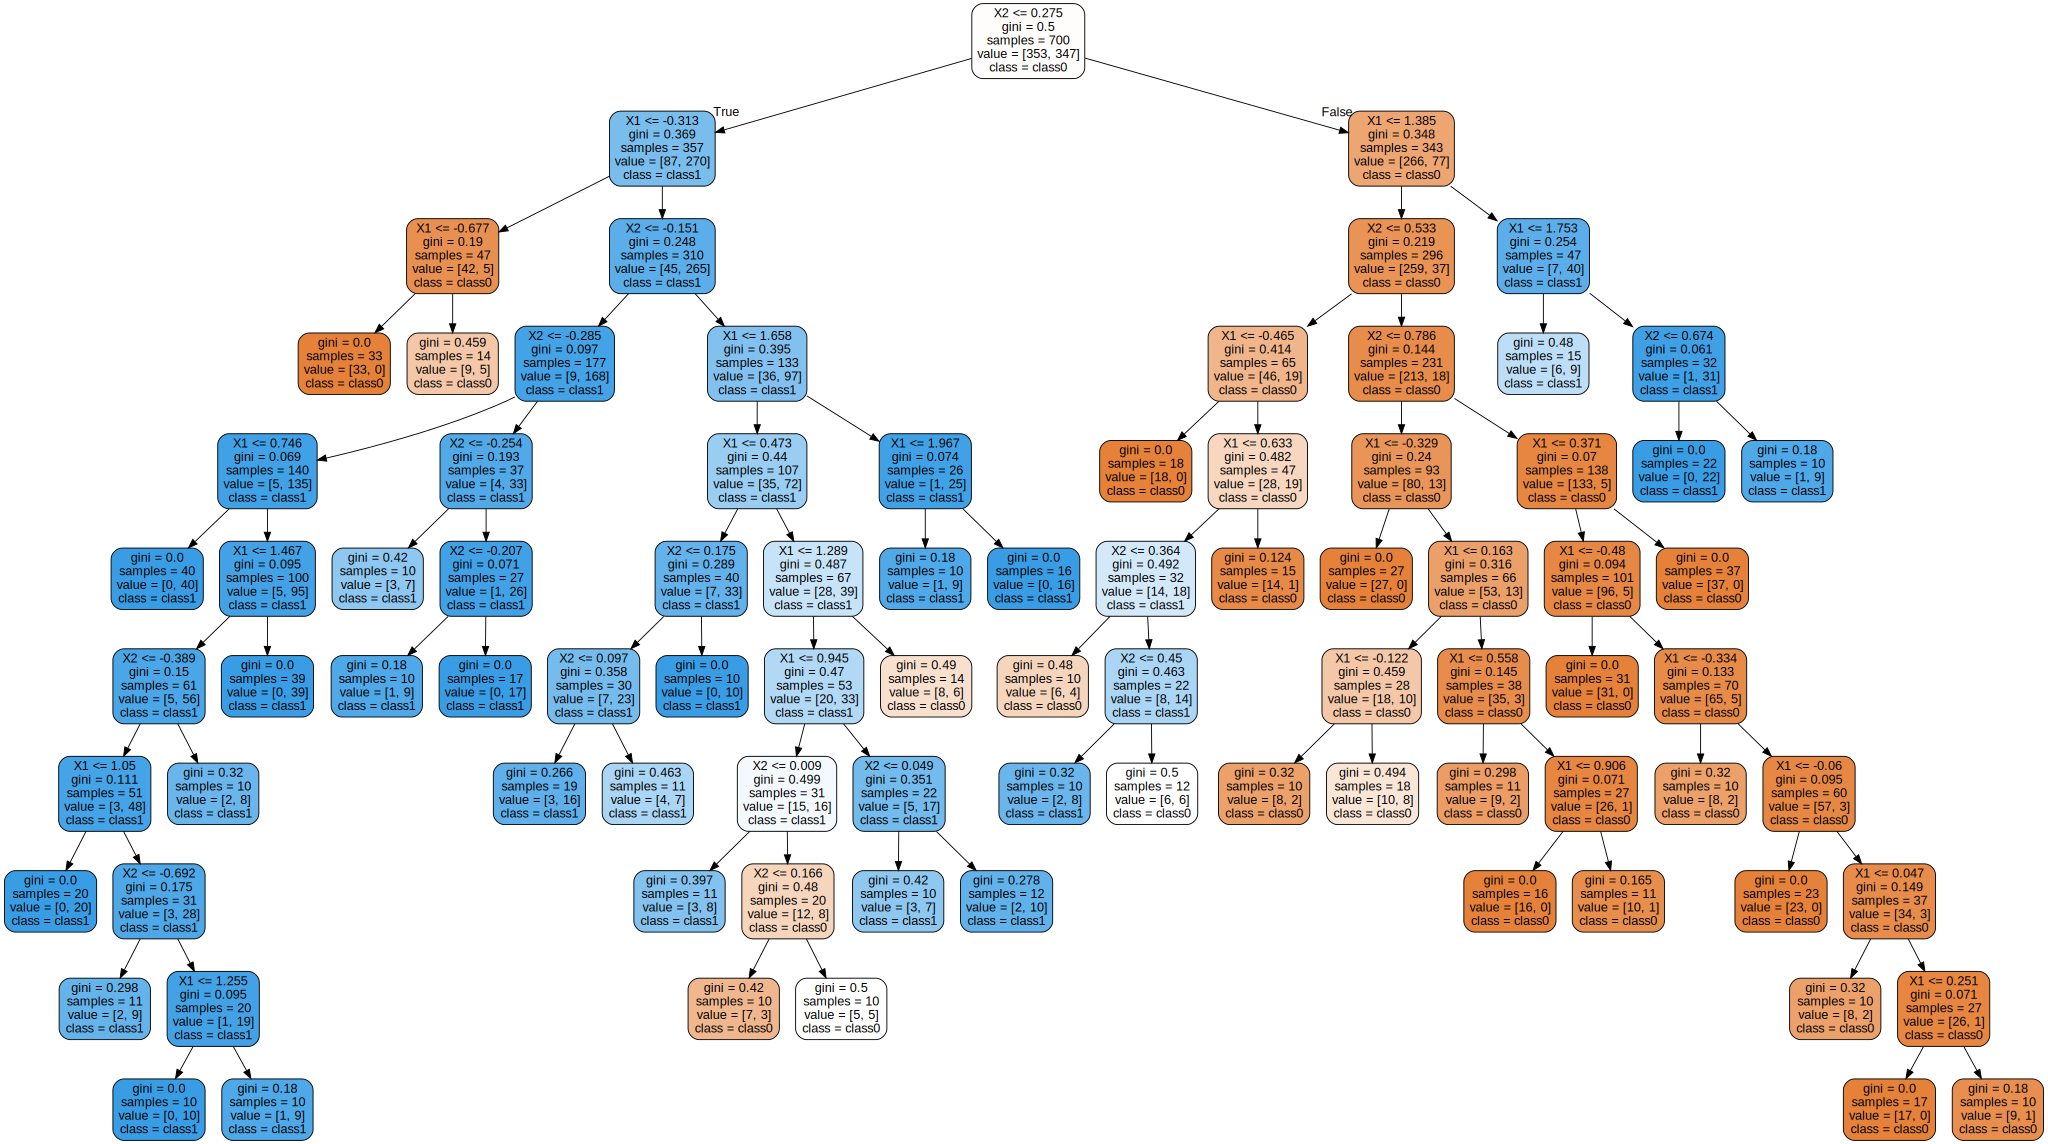

In [23]:
# 최종 결정 트리 시각화
from pathlib import Path
from sklearn.tree import export_graphviz
from graphviz import Source

IMAGES_PATH = Path() / 'images'/'decision_trees'
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

export_graphviz(
    best_tree_clf,
    out_file=str(IMAGES_PATH / 'moon_tree.dot'),
    feature_names=['X1', 'X2'],
    class_names=['class0', 'class1'],
    rounded=True,
    filled=True
)

Source.from_file(IMAGES_PATH/'moon_tree.dot')